In [1]:
from eclipsoid.ellipsoid import EclipsoidSystem, EllipsoidalBody
from jaxoplanet.starry.surface import Surface
from jaxoplanet.units import unit_registry as ureg
from jaxoplanet.orbits.keplerian import System, Central
from jaxoplanet.starry.orbit import SurfaceSystem
from jaxoplanet.starry.ylm import Ylm
from jax import config
config.update("jax_enable_x64", True)

import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt

# Modeling an ellipsoidal planet with eclipsoid:

In this notebook, I will walk through the main set of features of eclipsoid by modeling an ellipsoidal planet orbiting a star where both the planet and star are given a surface map.

In [2]:
y = Ylm.from_dense(np.hstack([1.0, np.random.rand(10) * 1e-1]))
central_surface = Surface(y=y, inc=0.9, obl=-0.3, period=1.2, u=[0.1, 0.1],amplitude=1.0)
central = Central(radius=1.0, mass=0.8)

y = Ylm.from_dense(np.hstack([1.0, np.random.rand(10) * 0.3]))
body_surface = Surface(y=y, inc=jnp.radians(30.), obl=0.0, period=1.0, u=[0.1, 0.1])
body = {
    "radius": 0.7,
    "mass": 0.6,
    "period": 1.0,
    "inclination":jnp.pi/2.,
    "surface": body_surface,
}


system = EclipsoidSystem(central, central_surface).add_body(radius=body['radius'], mass=body['mass'], period=body['period'], surface=body['surface'], inclination=body['inclination'],
                                                                   oblateness=0.0, prolateness=0.0)
spheres = SurfaceSystem(central, central_surface).add_body(**body)

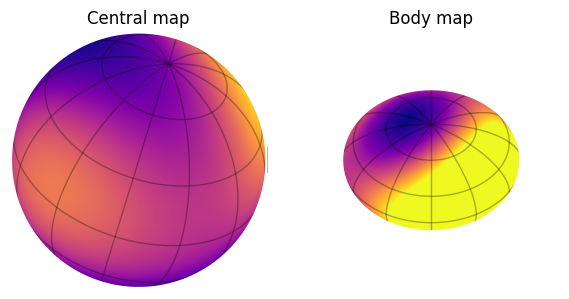

In [3]:
from eclipsoid.visualization import show_surface


def lim():
    radius = central.radius.magnitude
    plt.xlim(-radius, radius)
    plt.ylim(-radius, radius)


plt.figure(figsize=(6, 3))
plt.subplot(121)
show_surface(central_surface, vmax=0.4, theta=jnp.pi/2., cmap='plasma')
plt.title("Central map")
lim()
plt.subplot(122)
show_surface(body_surface, radius=body["radius"], vmax=0.4, oblateness=0.2, prolateness=0.2, theta=jnp.radians(0.), cmap='plasma')
lim()
plt.title("Body map")
_ = plt.tight_layout()

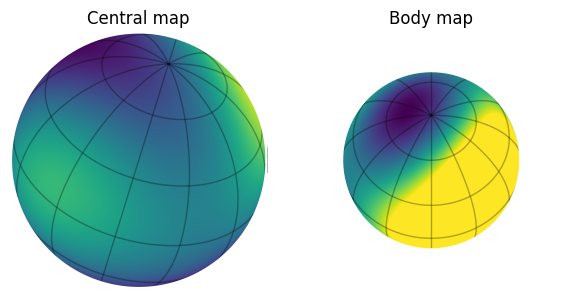

In [5]:
from jaxoplanet.starry.visualization import show_surface

def lim():
    radius = central.radius.magnitude
    plt.xlim(-radius, radius)
    plt.ylim(-radius, radius)


plt.figure(figsize=(6, 3))
plt.subplot(121)
show_surface(central_surface, vmax=0.4, theta=jnp.pi/2.)
plt.title("Central map")
lim()
plt.subplot(122)
show_surface(body_surface, radius=body["radius"], vmax=0.4, theta=jnp.radians(0.))
lim()
plt.title("Body map")
_ = plt.tight_layout()

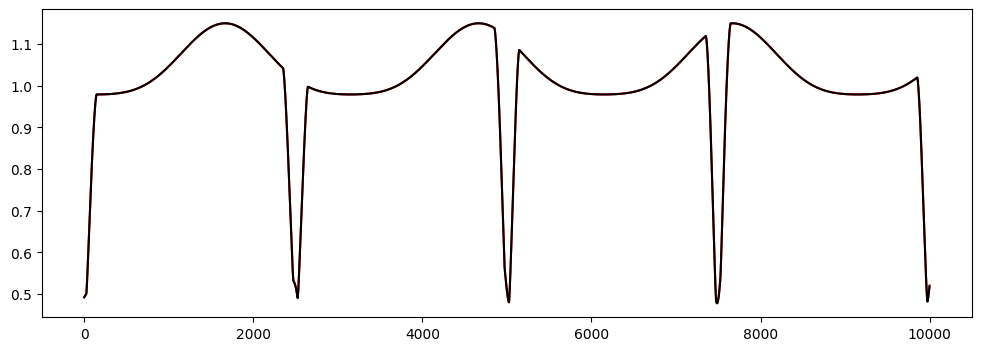

In [6]:
from jaxoplanet.starry.light_curves import light_curve
from eclipsoid.light_curve import eclipsoid_light_curve
from eclipsoid.light_curve import limb_dark_oblate_lightcurve

time = np.linspace(-2.0, 2.0, 10000)
flux_legacy = limb_dark_oblate_lightcurve(spheres, [0.1, 0.1], 0.1, 0.3)(time)

flux = eclipsoid_light_curve(system)(time)
flux_spherical = light_curve(spheres)(time)

plt.figure(figsize=(12, 4))
_ = plt.plot(flux_spherical[:,0], c="r")
#plt.plot(flux_legacy, c="b")
_ = plt.plot(flux[:,0], c="k")

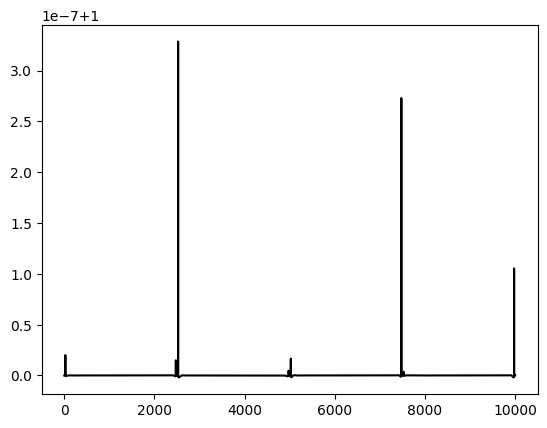

In [7]:
plt.plot(flux_spherical[:,0]/flux[:,0], c="k")

In [8]:
from jax import jit
elcs = jit(eclipsoid_light_curve(system))

In [9]:
%%timeit
elcs(time).block_until_ready()

263 ms ± 7.73 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
lcs = jit(light_curve(spheres))

In [11]:
%%timeit
lcs(time).block_until_ready()

50.5 ms ± 995 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)
